In [1]:
import os

import sys
sys.path.append("../project_functions/")
import ad_functions as adfns
import ad_crnn_functions as adcrn

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf

In [2]:
def list_image_files_in_directory(directory, extensions=("jpg", "jpeg", "png", "gif")):
    return [file for file in os.listdir(directory) if file.lower().endswith(extensions)]


In [3]:


image_directory = "./cropped_images/11"

image_files = list_image_files_in_directory(image_directory)

print("Image files in the directory:")
for image_file in image_files:
    print(image_file)


Image files in the directory:
S11_F01.png
S11_F02.png
S11_F03.png
S11_F04.png
S11_F05.png
S11_F06.png
S11_F07.png
S11_F08.png
S11_F09.png
S11_F10.png
S11_F11.png
S11_F12.png
S11_F13.png
S11_F14.png


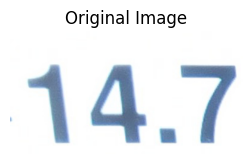

In [4]:
img_file = "./cropped_images/11/S11_F07.png"

image = cv2.imread(img_file)

adfns.show_img(image, size=3, title="Original Image")

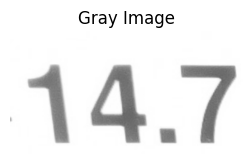

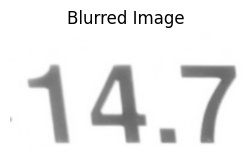

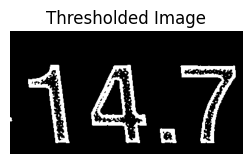

In [5]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

adfns.show_img(gray, size=3, title="Gray Image")
adfns.show_img(blurred, size=3, title="Blurred Image")
adfns.show_img(thresh, size=3, title="Thresholded Image")

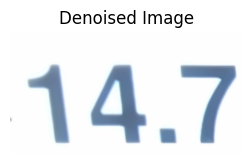

In [37]:
denoise = adfns.denoise_image(image)
adfns.show_img(denoise, size=3, title="Denoised Image")

In [6]:
contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# contours, _ = cv2.findContours(blurred.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

bounding_rectangles = [cv2.boundingRect(cnt) for cnt in contours]

# Sort bounding rectangles by their x-coordinate (left-to-right)
sorted_bounding_rectangles = sorted(bounding_rectangles, key=lambda x: x[0])

digit_images = []  # To store individual digit images

for rect in sorted_bounding_rectangles:
    x, y, w, h = rect

    # Optional: filter out contours based on aspect ratio and area
    aspect_ratio = w / float(h)
    area = w * h
    if 0.2 < aspect_ratio < 0.8 and area > 100:
        # Filter out small objects by area
        if area > 200:  # this cutoff is ad-hoc
            digit = thresh[y:y + h, x:x + w]
            digit_images.append(digit)

            # Draw a red bounding box around the digit
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)


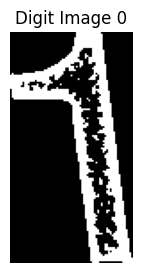

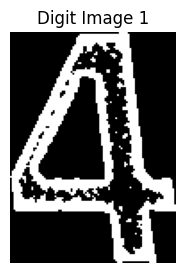

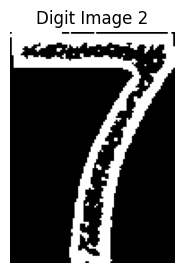

In [7]:
for i, digit_image in enumerate(digit_images):
    adfns.show_img(digit_image, size=3, title="Digit Image {}".format(i))

In [8]:
model_file = 'CRNN_s11_modded_digits_model.h5'
model = tf.keras.models.load_model(model_file)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0     

In [11]:
layers = model.layers
for i, layer in enumerate(layers):
    print(f"Layer {i}: {layer.name}")

Layer 0: input_1
Layer 1: conv2d
Layer 2: batch_normalization
Layer 3: activation
Layer 4: max_pooling2d
Layer 5: dropout
Layer 6: conv2d_1
Layer 7: batch_normalization_1
Layer 8: activation_1
Layer 9: max_pooling2d_1
Layer 10: dropout_1
Layer 11: conv2d_2
Layer 12: batch_normalization_2
Layer 13: activation_2
Layer 14: max_pooling2d_2
Layer 15: dropout_2
Layer 16: reshape
Layer 17: bidirectional
Layer 18: time_distributed
Layer 19: flatten
Layer 20: dropout_3
Layer 21: dense_1


In [12]:
input_shape = model.layers[0].input_shape
output_shape = model.layers[-1].output_shape

print(f"Model input shape: {input_shape}")
print(f"Model output shape: {output_shape}")


Model input shape: [(None, 32, 32, 1)]
Model output shape: (None, 10)


In [13]:
for i, layer in enumerate(layers):
    weights = layer.get_weights()
    if weights:
        print(f"Layer {i} ({layer.name}) weights:")
        for j, weight in enumerate(weights):
            print(f" - Weight {j}: {weight.shape}")
    else:
        print(f"Layer {i} ({layer.name}) has no weights.")


Layer 0 (input_1) has no weights.
Layer 1 (conv2d) weights:
 - Weight 0: (3, 3, 1, 32)
 - Weight 1: (32,)
Layer 2 (batch_normalization) weights:
 - Weight 0: (32,)
 - Weight 1: (32,)
 - Weight 2: (32,)
 - Weight 3: (32,)
Layer 3 (activation) has no weights.
Layer 4 (max_pooling2d) has no weights.
Layer 5 (dropout) has no weights.
Layer 6 (conv2d_1) weights:
 - Weight 0: (3, 3, 32, 64)
 - Weight 1: (64,)
Layer 7 (batch_normalization_1) weights:
 - Weight 0: (64,)
 - Weight 1: (64,)
 - Weight 2: (64,)
 - Weight 3: (64,)
Layer 8 (activation_1) has no weights.
Layer 9 (max_pooling2d_1) has no weights.
Layer 10 (dropout_1) has no weights.
Layer 11 (conv2d_2) weights:
 - Weight 0: (3, 3, 64, 128)
 - Weight 1: (128,)
Layer 12 (batch_normalization_2) weights:
 - Weight 0: (128,)
 - Weight 1: (128,)
 - Weight 2: (128,)
 - Weight 3: (128,)
Layer 13 (activation_2) has no weights.
Layer 14 (max_pooling2d_2) has no weights.
Layer 15 (dropout_2) has no weights.
Layer 16 (reshape) has no weights.
Lay

In [14]:
model_config = model.get_config()
print(model_config)


{'name': 'model', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 32, 32, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'name': 'input_1', 'inbound_nodes': []}, {'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'conv2d', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization', 'trainable': True, 'dtype': 'float32', 'axis': ListWrapper([3]), 'momentum':

In [9]:
def preprocess_digit_image(digit_image, target_size=(32, 32)):
    resized_digit = cv2.resize(digit_image, target_size, interpolation=cv2.INTER_AREA)
    return resized_digit / 255.0



In [10]:
preprocessed_digits = [preprocess_digit_image(digit_image) for digit_image in digit_images]


In [15]:
predictions = model.predict(np.array(preprocessed_digits).reshape(-1, 32, 32, 1))
predicted_digits = np.argmax(predictions, axis=1)

for i, digit in enumerate(predicted_digits):
    print(f"Digit {i}: {digit}")


1/1 [==============================] - 0s 24ms/step
Digit 0: 3
Digit 1: 9
Digit 2: 7


In [30]:
dir(adfns)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'control_loop_sipa3',
 'crop_image',
 'cv2',
 'delete_file',
 'denoise_image',
 'display_four_images',
 'display_ten_images',
 'get_rotation_angle',
 'get_text',
 'get_text_lets',
 'invert_thresh',
 'is_image',
 'mask_green',
 'mask_red',
 'np',
 'os',
 'pd',
 'plot_label_frequencies',
 'plt',
 'preprocess_motsu_image',
 'process_adaptive_gaussian',
 'process_deblurred_image',
 'process_file_closing',
 'process_file_thresh',
 'process_otsu',
 'pytesseract',
 'random',
 're',
 'read_dot_matrix_image',
 'read_input_file_list',
 'read_resize_data',
 'rotate_image',
 'show_img']

In [1]:
import pandas as pd
from IPython.display import HTML

# this function adds some CSS to our dataframe
def upsidedown(df):
    html = '''<style>
            .dataframe {transform: rotate(180deg)}
        </style>''' + df.to_html()
    display(HTML(html))

In [2]:
df = pd.DataFrame([
    ['apple', 4],['orange', 5],['pear', 6],
    ['pineapple', 7], ['banana', 8],
], columns=['fruit', 'price'])

upsidedown(df)

,fruit,price
0,apple,4
1,orange,5
2,pear,6
3,pineapple,7
4,banana,8


In [ ]:
import turtle
screen = turtle.getscreen()
x = turtle.Turtle()
for i in range(1000):
    x.forward(200)
    x.right(115)

In [4]:
import webbrowser
webbrowser.open_new("https://medium.com")

True